In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random


In [2]:
np.random.seed(42)

# total samples = 400 (5 classes → 80 each)
n_classes = 5
samples_per_class = 80

X, Y, labels = [], [], []

# cluster centers for 5 classes
centers = [(2, 2), (6, 2), (2, 6), (6, 6), (4, 4)]

for label, (cx, cy) in enumerate(centers):
    X.extend(np.random.normal(cx, 0.5, samples_per_class))
    Y.extend(np.random.normal(cy, 0.5, samples_per_class))
    labels.extend([label] * samples_per_class)

# make dataframe
df = pd.DataFrame({
    "X": X,
    "Y": Y,
    "LABEL": labels
})

# save to CSV
df.to_csv("data.csv", index=False)
print("CSV file saved as data.csv")


CSV file saved as data.csv


In [3]:
data = pd.read_csv('data.csv')
print(df.shape) # 400 input-output combinations for the total dataset
df.head(df.shape[0])

(400, 3)


,X,Y,LABEL
0,2.248357,1.890164,0
1,1.930868,2.178556,0
2,2.323844,2.738947,0
3,2.761515,1.740865,0
4,1.882923,1.595753,0
...,...,...,...
395,4.551651,4.526576,4
396,4.057114,3.980222,4
397,4.075151,4.340750,4
398,3.818194,4.014159,4


In [4]:
# one-hot encoding for labels 0–4
def normalize(label):
    if label == 0:
        return [1, 0, 0, 0, 0]
    elif label == 1:
        return [0, 1, 0, 0, 0]
    elif label == 2:
        return [0, 0, 1, 0, 0]
    elif label == 3:
        return [0, 0, 0, 1, 0]
    elif label == 4:
        return [0, 0, 0, 0, 1]

In [5]:
X1 = df["X"].values.tolist()
X2 = df["Y"].values.tolist()
Y  = df["LABEL"].values.tolist()

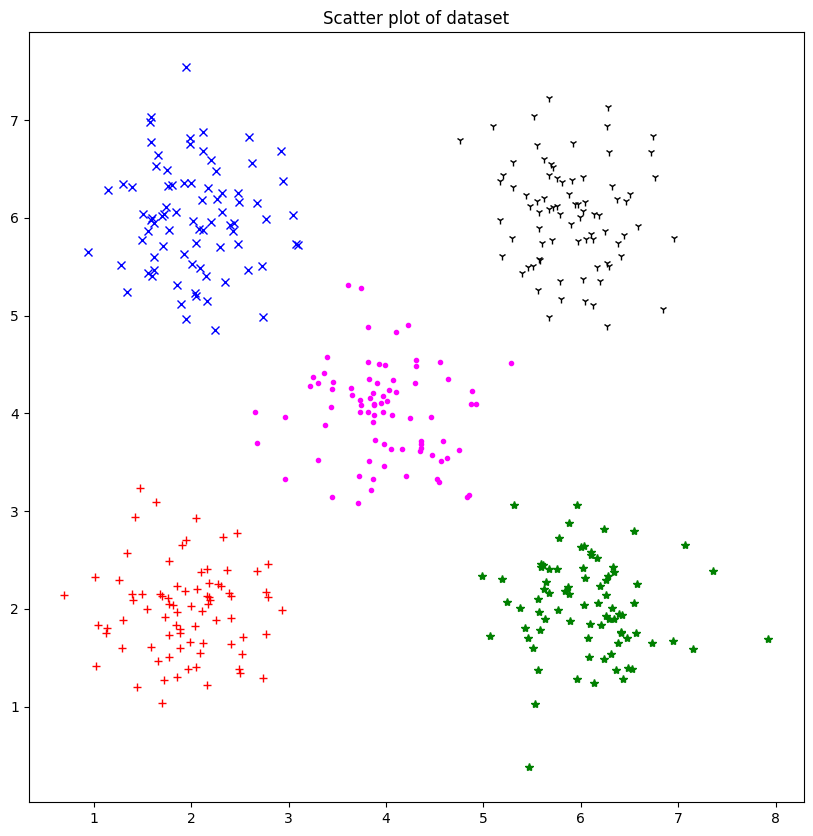

In [6]:
#plotting all points

plt.figure(figsize=(10,10))
for i in range(len(Y)):
    if Y[i] == 0:
        plt.plot(X1[i], X2[i], c="red", marker="+")
    elif Y[i] == 1:
        plt.plot(X1[i], X2[i], c="green", marker="*")
    elif Y[i] == 2:
        plt.plot(X1[i], X2[i], c="blue", marker="x")
    elif Y[i] == 3:
        plt.plot(X1[i], X2[i], c="black", marker="1")
    elif Y[i] == 4:
        plt.plot(X1[i], X2[i], c="magenta", marker=".")
plt.title("Scatter plot of dataset")
plt.show()

In [7]:
features = list(zip(X1, X2)) #zipping the 2 input features into a list

features_np = np.array(features) #converting the list into a numpy array

In [8]:
# normalizing the output labels to be one-hot encoded and
 # turning it into a numpy array

Y2 = np.array([normalize(i) for i in Y])

In [9]:

# Combine features and labels
combined = list(zip(features_np, Y2))
np.random.shuffle(combined)

# Unzip back
features_np, Y2 = zip(*combined)
features_np = np.array(features_np)
Y2 = np.array(Y2)

# 80:20 split
split = int(0.8 * len(features_np))
features_train, features_test = features_np[:split], features_np[split:]
Y2_train, Y2_test = Y2[:split], Y2[split:]


# Neural Network - Training & testing

In [10]:
class NeuralNetwork:
    def __init__(self, activation_type='relu', learning_rate=0.01):
        # Layer sizes
        inputLayerNeurons = 2
        hidden1Neurons = 20
        hidden2Neurons = 20
        hidden3Neurons = 20
        outLayerNeurons = 5
        
        self.activation_type = activation_type
        self.learning_rate = learning_rate
        
        # Random weight initialization
        self.W_H1 = np.random.randn(inputLayerNeurons, hidden1Neurons)
        self.W_H2 = np.random.randn(hidden1Neurons, hidden2Neurons)
        self.W_H3 = np.random.randn(hidden2Neurons, hidden3Neurons)
        self.W_O  = np.random.randn(hidden3Neurons, outLayerNeurons)
    
    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der:
                return np.exp(-x) / (1 + np.exp(-x))**2
            return 1 / (1 + np.exp(-x))
        if self.activation_type == 'relu':
            if der:
                return np.where(x > 0, 1, 0)
            return np.maximum(0, x)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def feedForward(self, X):
        self.H1_out = self.activation(np.dot(X, self.W_H1))
        self.H2_out = self.activation(np.dot(self.H1_out, self.W_H2))
        self.H3_out = self.activation(np.dot(self.H2_out, self.W_H3))
        self.output = self.softmax(np.dot(self.H3_out, self.W_O))
        return self.output
    
    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error
        
        H3_error = output_delta.dot(self.W_O.T)
        H3_delta = self.learning_rate * H3_error * self.activation(self.H3_out, der=True)
        
        H2_error = H3_delta.dot(self.W_H3.T)
        H2_delta = self.learning_rate * H2_error * self.activation(self.H2_out, der=True)
        
        H1_error = H2_delta.dot(self.W_H2.T)
        H1_delta = self.learning_rate * H1_error * self.activation(self.H1_out, der=True)
        
        # Update weights
        self.W_H1 += X.T.dot(H1_delta)
        self.W_H2 += self.H1_out.T.dot(H2_delta)
        self.W_H3 += self.H2_out.T.dot(H3_delta)
        self.W_O  += self.H3_out.T.dot(output_delta)
    
    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)


# Training and Evaluation

Epoch 0, Loss: 6.1113
Epoch 1000, Loss: 0.2454
Epoch 2000, Loss: 0.1520
Epoch 3000, Loss: 0.1086
Epoch 4000, Loss: 0.0841
Epoch 5000, Loss: 0.0685
Epoch 6000, Loss: 0.0576
Epoch 7000, Loss: 0.0496
Epoch 8000, Loss: 0.0436
Epoch 9000, Loss: 0.0388
Epoch 10000, Loss: 0.0350
Epoch 11000, Loss: 0.0318
Epoch 12000, Loss: 0.0292
Epoch 13000, Loss: 0.0270
Epoch 14000, Loss: 0.0251


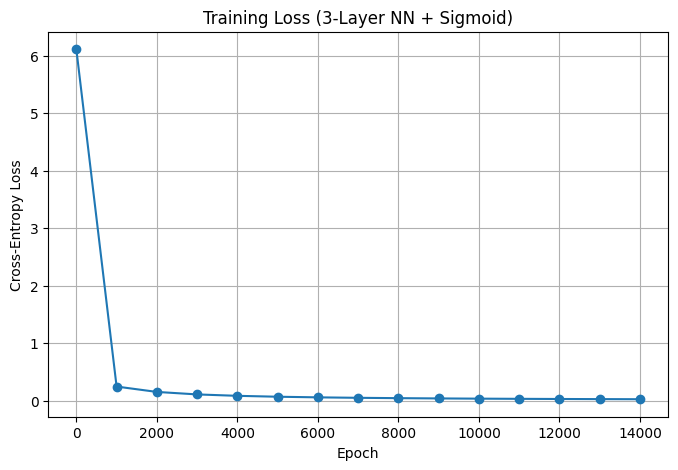

In [11]:
NN = NeuralNetwork(activation_type='sigmoid', learning_rate=0.01)

#NN = NeuralNetwork(activation_type='relu', learning_rate=0.01)

# Cross-entropy loss function
def crossentropy(pred, Y_true):
    pred = np.clip(pred, 1e-8, 1.0 - 1e-8)
    return np.mean(-np.sum(Y_true * np.log(pred), axis=1))

# Training
epochs = 15000
loss_history = []

for i in range(epochs):
    NN.train(features_train, Y2_train)
    pred_train = NN.feedForward(features_train)
    loss = crossentropy(pred_train, Y2_train)
    
    if i % 1000 == 0:
        loss_history.append(loss)
        print(f"Epoch {i}, Loss: {loss:.4f}")

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(range(0, epochs, 1000), loss_history, marker='o')
plt.title("Training Loss (3-Layer NN + Sigmoid)")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()


# Performance Metrics

In [12]:
pred_test = NN.feedForward(features_test)
Y_pred = np.argmax(pred_test, axis=1)
Y_true = np.argmax(Y2_test, axis=1)

# Evaluation
accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average=None, zero_division=0)
recall = recall_score(Y_true, Y_pred, average=None, zero_division=0)
f1 = f1_score(Y_true, Y_pred, average=None, zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
for i, p in enumerate(precision):
    print(f"Class {i}: Precision={p:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}")

print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, zero_division=0))


Overall Accuracy: 0.9875
Class 0: Precision=1.00, Recall=1.00, F1=1.00
Class 1: Precision=1.00, Recall=1.00, F1=1.00
Class 2: Precision=1.00, Recall=1.00, F1=1.00
Class 3: Precision=1.00, Recall=0.95, F1=0.97
Class 4: Precision=0.93, Recall=1.00, F1=0.96

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        16
           3       1.00      0.95      0.97        19
           4       0.93      1.00      0.96        13

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



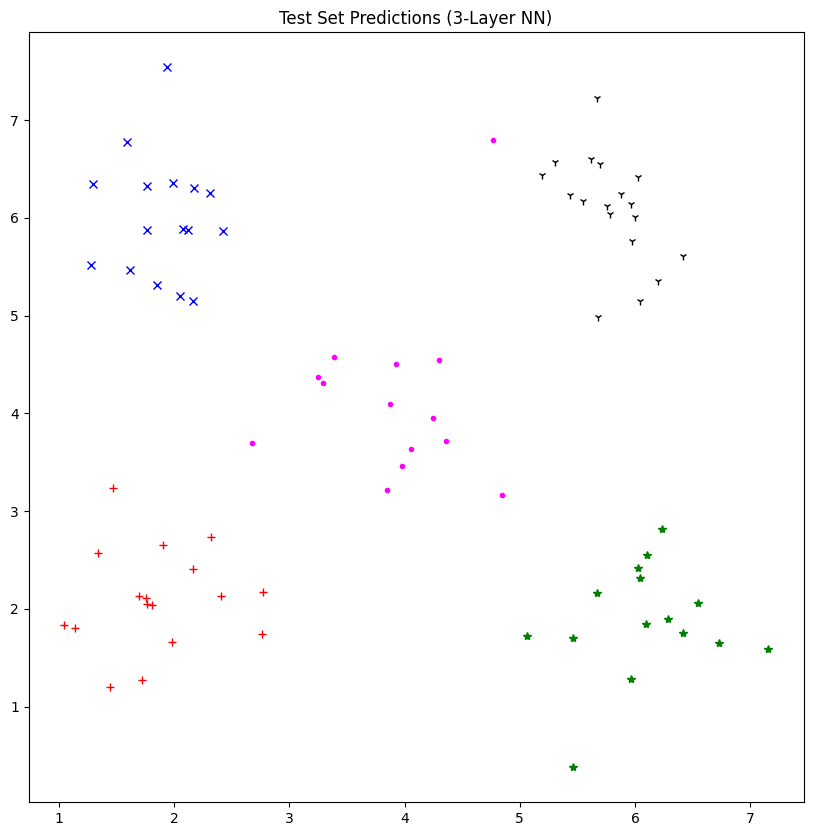

In [13]:
colors = ['red', 'green', 'blue', 'black', 'magenta']
markers = ['+', '*', 'x', '1', '.']

plt.figure(figsize=(10,10))
for i in range(len(features_test)):
    label = Y_pred[i]
    plt.plot(features_test[i][0], features_test[i][1], c=colors[label], marker=markers[label])

plt.title("Test Set Predictions (3-Layer NN)")
plt.show()